In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import itertools
from itertools import combinations
from scipy import spatial
import pickle as pickle
import gudhi
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import io
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageChops, ImageFont
import shapely.geometry as geom
from shapely.ops import unary_union
import warnings

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### combining my study with previous study - Trying to create SC for single filteration level

In [3]:
#first create the grid system

In [4]:
# Create a DataFrame with box names and values
box_names = [chr(65 + i) for i in range(16)]
values = list(range(0, 16))
values_1 = [1,2,3,4,8,7,6,5,9,10,11,12,16,15,14,13]
values_2 = list(range(1, 17))
df = pd.DataFrame({'FIPS': box_names, 'Value': values,'Value_1': values_1,'Value_2': values_2})

In [5]:
df

,FIPS,Value,Value_1,Value_2
0,A,0,1,1
1,B,1,2,2
2,C,2,3,3
3,D,3,4,4
4,E,4,8,5
5,F,5,7,6
6,G,6,6,7
7,H,7,5,8
8,I,8,9,9
9,J,9,10,10


In [9]:
# Function to calculate square coordinates for a given name
def calculate_square_coordinates(row):
    box_name = row['FIPS']
    value = row['Value']
    # Assuming each smaller square has a side length of 1 unit
    x = value % 4
    y = value // 4
    # Return square coordinates as a Shapely polygon
    return geom.Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)])

In [10]:
# Calculate square coordinates for each row and create a geometry column
df['geometry'] = df.apply(calculate_square_coordinates, axis=1)

In [11]:
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

In [12]:
# Set the CRS to a simple Cartesian coordinate system
gdf.crs = "EPSG:3395"  # This is a commonly used projected CRS

In [13]:
gdf

,FIPS,Value,Value_1,Value_2,geometry
0,A,0,1,1,"POLYGON ((0.000 0.000, 1.000 0.000, 1.000 1.00..."
1,B,1,2,2,"POLYGON ((1.000 0.000, 2.000 0.000, 2.000 1.00..."
2,C,2,3,3,"POLYGON ((2.000 0.000, 3.000 0.000, 3.000 1.00..."
3,D,3,4,4,"POLYGON ((3.000 0.000, 4.000 0.000, 4.000 1.00..."
4,E,4,8,5,"POLYGON ((0.000 1.000, 1.000 1.000, 1.000 2.00..."
5,F,5,7,6,"POLYGON ((1.000 1.000, 2.000 1.000, 2.000 2.00..."
6,G,6,6,7,"POLYGON ((2.000 1.000, 3.000 1.000, 3.000 2.00..."
7,H,7,5,8,"POLYGON ((3.000 1.000, 4.000 1.000, 4.000 2.00..."
8,I,8,9,9,"POLYGON ((0.000 2.000, 1.000 2.000, 1.000 3.00..."
9,J,9,10,10,"POLYGON ((1.000 2.000, 2.000 2.000, 2.000 3.00..."


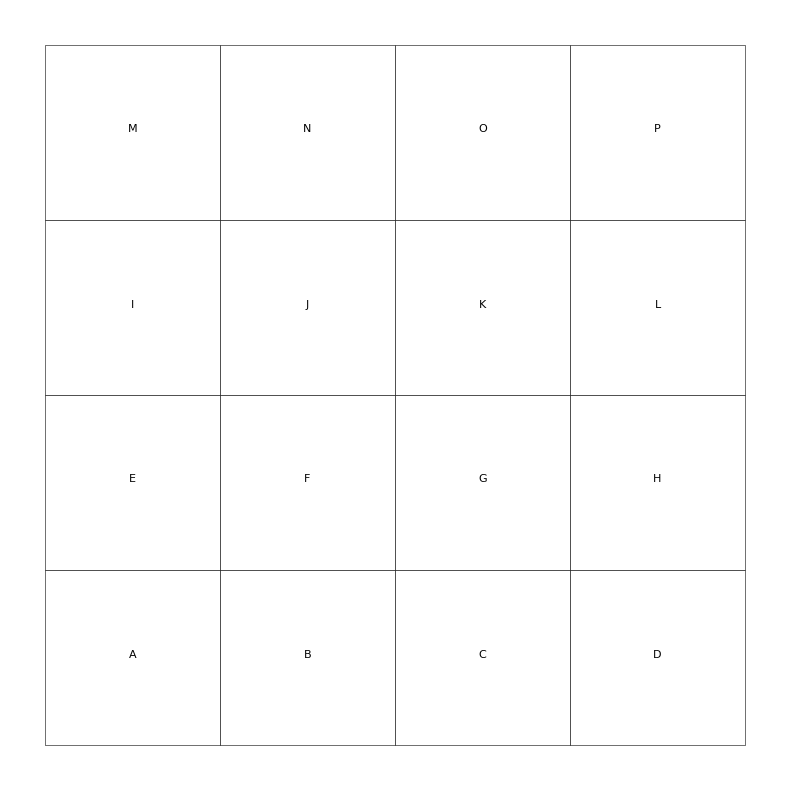

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('white')

# Remove the axis
ax.axis('off')

# Plot the data on the specified Axes object
gdf.plot( edgecolor='black', linewidth=0.4, ax=ax, color='white')

# Plot the centroid of the large square with values
for i, row in gdf.iterrows():
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, str(row['FIPS']), fontsize=8, ha='center')

# Display the plot
plt.show()

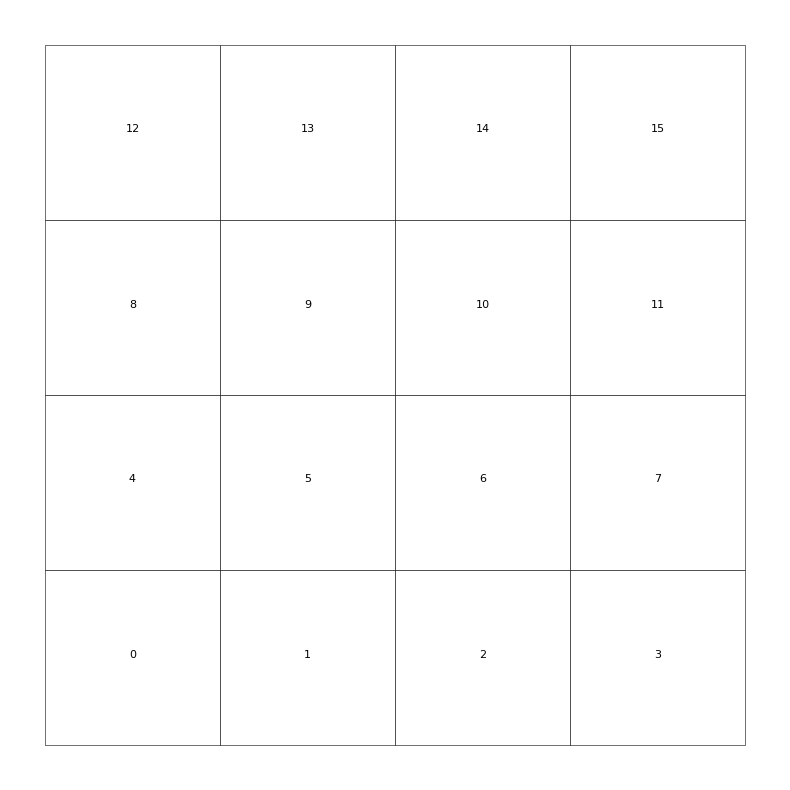

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('white')

# Remove the axis
ax.axis('off')

# Plot the data on the specified Axes object
gdf.plot( edgecolor='black', linewidth=0.4, ax=ax, color='white')

# Plot the centroid of the large square with values
for i, row in gdf.iterrows():
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, str(row['Value']), fontsize=8, ha='center')

# Display the plot
plt.show()

In [16]:
# Now let's apply fileration level and then create the adjacent counties for each county

In [36]:
filtration_threshold_ = 6
filtered_df = gdf[gdf['Value_1'] < filtration_threshold_]

In [37]:
# Perform a spatial join to find adjacent precincts
adjacent_precincts = gpd.sjoin(filtered_df, filtered_df, predicate='intersects', how='left')

 # Filter the results to include only the adjacent states
adjacent_precincts = adjacent_precincts.query('Value_left != Value_right')

# Group the resulting dataframe by the original precinct Name and create a list of adjacent precinct Name
adjacent_precincts = adjacent_precincts.groupby('Value_left')['Value_right'].apply(list).reset_index()

In [38]:
adjacent_precincts.rename(columns={'Value_left': 'county', 'Value_right': 'adjacent'}, inplace=True)

In [39]:
adjacent_precincts

,county,adjacent
0,0,[1]
1,1,"[0, 2]"
2,2,"[1, 3, 7]"
3,3,"[2, 7]"
4,7,"[2, 3]"


In [46]:
adjacent_precincts['rate'] = ['0','1','2','3','4']

In [47]:
adjacent_precincts

,county,adjacent,rate
0,0,[1],0
1,1,"[0, 2]",1
2,2,"[1, 3, 7]",2
3,3,"[2, 7]",3
4,7,"[2, 3]",4


In [41]:
# Now let's create the simplicial complex

In [42]:
def lower_neighbors(adjacencies, vertex):
    return [v for v in adjacencies[vertex] if v < vertex]

In [43]:
def add_cofaces(adjacencies, maxDimension, face, N, V):
    if sorted(face) not in V:
        V.append(sorted(face))
    if len(face) >= maxDimension:
        return
    else:
        for vertex in N:
            coface = list(face)
            coface.append(vertex)
            M = list(set(N) & set(lower_neighbors(adjacencies, vertex)))
            add_cofaces(adjacencies, maxDimension, coface, M, V)

In [44]:
def incremental_vr(V, adjacencies, maxDimension):
    Vnew = list(V)
    for vertex in np.arange(len(adjacencies)):
        N = sorted(lower_neighbors(adjacencies, vertex))
        add_cofaces(adjacencies, maxDimension, [vertex], N, Vnew)
    return Vnew

In [ ]:
def form_simplicial_complex(county_list):
    maxDimension = 3
    